# Imports

In [17]:
# Imports
import numpy as np
import pandas as pd
import pyspark
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import contractions
import math
from itertools import chain
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
from nltk.stem import WordNetLemmatizer

import re
import string
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from google.cloud import bigquery

import matplotlib.ticker as mtick
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [18]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

client = bigquery.Client(location="US", project="helio-staging")

Client creating using default project: helio-staging


In [19]:
GROUP_CUSTOM_STOPWORDS = [
    "bike", "nbsp", "crn","sample", "bikes", "great", "good", "love","like", "recommend","smells","collected","part","review","promotion","razor",
    "shave","shaving","blade","camille","cantu","daughter","today","kccc","jessie","miss","fabric","pillow","softener","or",    "tiktok","OR",
     'Proov', 'proov','Natalist', 'natalist','Stix', 'stix','Clear Blue', 'blue','Modern Fertility', 'modern', 'free', 'app', 'mf', 'android', 'pinchme',
    'Pregmate', 'pregmate', 'received','First Response', 'test', 'ovulation', 'none', 'see', 'store', 'day', 'month', 'amy', 'face', 'far', 'scan',
    'it‚äôs','don‚äôt', 'using_minoxidil', '_oz','i‚äôm','moreread','using','stating',
    'doesn‚äôt', 'classic','order','ordering', 'best', 'hard', 'seltzer', 'claw','never','got','ordered','white','product','high-noon','bottle','girl',
    'read_lessread','read_moreread','lessread_le','le_stating','moreread_stating','scalp detox','le_serum',
    'moreread_serum','i’ve_stem','hair_read','don’t_know','i’ve_bought', 'liquid_kinda', "i'ḿ"'use_serum','le_mus','read_serum','ingredient_us','oz_extreme',
    'cell_serum','cell','stem','le','read','lessread','moreread','more','multi-colored—from_brown','findin_read','strengthening_hair','hair_oil','care_oil',
    'hair','oil_hair','extreme_hair','hair_care','extreme','oz','_strengthening','used twice', 'oil_oil', 'customer',    'nan', 'read_moreread', 'noreferrer',
    'noreferrer_farmer','farmer_dog/a','noreferrer_ollie/a','rel','noopener','blank_rel',
    'rel_nofollow','blank','nofollow','target_blank','noopener_noreferrer','nofollower_noopener','nofollow_noopener',"partake","partake_cooky", "crunchy_cooky","cooky_vegan","madegood"
]

added_stopwords_li = [
    "it’s",    "'d",    "'s",
    "n't",    "'m",
    "i've",    "it's",    "'ve",
    "'re",    "'ll",    "``",    "''",    "...",    "--", "https",
    "voxbox",    "influenster",    "cracker",    "or",    'it‚äôs',
    'don‚äôt',    'i‚äôm',    'doesn‚äôt',    "get", "also",    "even",    "since", "amy"
]

REV_COLS = ['source_name',
    'normalized_url',
    'review_source_id',
    'reviewer_source_id',
    'brand_name',
    'product_name',
    'product_source_id',
    'review_date',
    'review_rating',
    'review_content'
]

product_categories = ['Accessories',
'Alcoholic Beverages',
'Apparel & Footwear',
'Food',
'Food Establishments',
'Health & Beauty Establishments',
'Household Consumables',
'Household Durables',
'Other',
'Pet Products',
'Non-Alcoholic Beverages',
'Personal Care & Beauty',
'Retailers',
'Sports & Outdoors'
]

drop_words = ['cooky',
              'partake',
              'madegood']

MIN_TERM_PCT = 0

MAX_TERM_PCT = 100

TERM_PERCENT_HEAD = 1

TOP_N_WORDS = 8

np.random.seed(42) # set seed for models for reproducibility

stopwords_li = stopwords.words('english')
punkts_li = list(string.punctuation)

REVIEWS_PER_BRAND_TO_ANALYZE = 10_000

In [20]:
def tokenize(s, strip_str="=-_/\+.:,'* 1234567890—"):
    custom_words_li = GROUP_CUSTOM_STOPWORDS + added_stopwords_li+stopwords_li + punkts_li + [""]
    return [w.lower().strip(strip_str) for w in word_tokenize(str(s)) if w.lower().strip(strip_str) not in custom_words_li]

def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in tokens]

def unique_list(li):
    deduped_li = list(set(li))
    return deduped_li

def bigram(tokens):
    bi_tup = list(bigrams(tokens))
    bi_li = ['_'.join(tup) for tup in bi_tup]
    return bi_li


# Load Data

In [21]:
GROUP_NAME = "Non-Dairy"
# GROUP_NAME = 'Meat Substitutes'


# When using Streamlit, leave list empty and un-comment cells below
NORMALIZED_URL_LI = [
    'nutpods.com',
    'sodeliciousdairyfree.com',
    'coffeemate.com',
    'califiafarms.com',
    'silk.com',
]




BRAND_NAME_LI = [
    'Nutpods',
    'So Delicious',
    'Coffee Mate',
    'Califia',
    'Silk'
]

REV_COLS = ['source_name',
    'normalized_url',
    'review_source_id',
    'reviewer_source_id',
    'brand_name',
    'product_name',
    'product_source_id',
    'review_date',
    'review_rating',
    'review_content'
]

brand_name_di = dict(zip(NORMALIZED_URL_LI, BRAND_NAME_LI))

REVIEWS_PER_BRAND_TO_ANALYZE = 10_000
    

In [ ]:
GROUP_NAME = "Non-Dairy"
# GROUP_NAME = 'Meat Substitutes'


# When using Streamlit, leave list empty and un-comment cells below
NORMALIZED_URL_LI = [
    'nutpods.com',
    'sodeliciousdairyfree.com',
    'coffeemate.com',
    'califiafarms.com',
    'silk.com',
]




BRAND_NAME_LI = [
    'Nutpods',
    'So Delicious',
    'Coffee Mate',
    'Califia',
    'Silk'
]

REV_COLS = ['source_name',
    'normalized_url',
    'review_source_id',
    'reviewer_source_id',
    'brand_name',
    'product_name',
    'product_source_id',
    'review_date',
    'review_rating',
    'review_content'
]

brand_name_di = dict(zip(NORMALIZED_URL_LI, BRAND_NAME_LI))

REVIEWS_PER_BRAND_TO_ANALYZE = 10_000
    

In [22]:
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("url", "STRING", NORMALIZED_URL_LI),
        bigquery.ArrayQueryParameter("cols", "STRING", REV_COLS),
        bigquery.ArrayQueryParameter("brands", "STRING", BRAND_NAME_LI)
    ]
)

In [23]:
job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ArrayQueryParameter("url", "STRING", NORMALIZED_URL_LI)
        ]
)
max_date_query = """
    SELECT max(execution_date)
    FROM `helio-staging.online_reviews.online_reviews__deduped_review__1_0`
    where execution_date > DATE_ADD(current_date(), INTERVAL -10 DAY)
    and normalized_url IS NOT NULL
    """
query_job = client.query(
    max_date_query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
    job_config=job_config
)  # API request - starts the query

max_date = query_job.to_dataframe()['f0_'].astype('str')[0]


In [24]:
max_date

'2022-03-23'

In [25]:
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("url", "STRING", NORMALIZED_URL_LI),
        bigquery.ScalarQueryParameter("max_date", "STRING", max_date)
    ]
)
review_query = """
    SELECT source_name,
    normalized_url,
    review_source_id,
    reviewer_source_id,
    product_name,
    product_source_id,
    review_date,
    review_rating,
    review_content
    FROM `helio-staging.online_reviews.online_reviews__deduped_review__1_0`
    WHERE normalized_url IN UNNEST (@url)
    AND execution_date = @max_date
    """
query_job = client.query(
    review_query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
    job_config=job_config
)  # API request - starts the query

reviews = query_job.to_dataframe()
reviews = reviews.loc[reviews.astype(str).drop_duplicates().index]


In [26]:
reviews.shape


(55347, 9)

In [27]:
amzn_reviews = reviews[reviews["source_name"]=="amazon"]
amzn_reviews.shape

(33838, 9)

In [28]:
revs_dist = amzn_reviews.groupby("normalized_url")["reviewer_source_id"].value_counts().reset_index(name='counts')

califiafarms.com
Number of unique reviewers:6465
Number of repeat reviewers:284
Pct of repeat reviewers: 4.39%
nutpods.com
Number of unique reviewers:13061
Number of repeat reviewers:982
Pct of repeat reviewers: 7.52%
silk.com
Number of unique reviewers:7016
Number of repeat reviewers:391
Pct of repeat reviewers: 5.57%
sodeliciousdairyfree.com
Number of unique reviewers:4640
Number of repeat reviewers:285
Pct of repeat reviewers: 6.14%

Repeat customers


KeyError: 'repeat_customer'

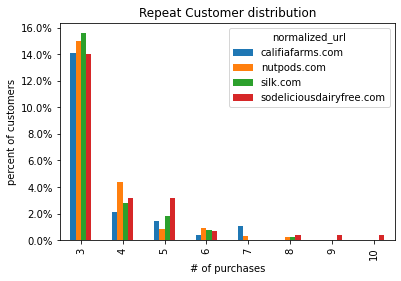

In [29]:
#percent of repeat customers

import matplotlib.ticker as mtick

for i in revs_dist["normalized_url"].unique():
    print (i)
    rev_count = revs_dist[revs_dist["normalized_url"]==i]["normalized_url"].count()
    repeat_rev = revs_dist[(revs_dist["normalized_url"]==i) & (revs_dist["counts"]>1) ]["normalized_url"].count()
    print ("Number of unique reviewers:" + str (rev_count))
    print ("Number of repeat reviewers:" + str (repeat_rev))
    print ("Pct of repeat reviewers: " + str (round((repeat_rev/rev_count)*100,2)) + "%")

'''
Takeaway:
    - number of reviews correlate with number of repeat reviews -> bigger brands have more repeat reviews
        - lower repeat could indicate growth potential
        - higher repeat could indicate more effective 

'''
    
#distribution of repeat customers
revs_dist_repeats = revs_dist[revs_dist["counts"]>1]
revs_dist_repeats_dist = revs_dist_repeats.groupby("normalized_url")["counts"].value_counts(normalize = True)
revs_dist_repeats_dist = revs_dist_repeats_dist.reset_index(name='pct')
revs_dist_repeats_dist = revs_dist_repeats_dist[revs_dist_repeats_dist["counts"]>2]
repeat_customers = revs_dist_repeats_dist.pivot_table(index = "counts", columns = "normalized_url", values = "pct")*100

fig = repeat_customers.plot.bar(title = "Repeat Customer distribution", xlabel = "# of purchases", ylabel = "percent of customers")

fig.yaxis.set_major_formatter(mtick.PercentFormatter())

#avg number of skus of repeat customers
print("\nRepeat customers")

sku_dist = amzn_reviews[amzn_reviews["repeat_customer"]>1][["normalized_url","reviewer_source_id","product_name"]]

print(sku_dist.groupby(["normalized_url","reviewer_source_id"])["product_name"].count().reset_index(name="Avg # of SKUs").groupby("normalized_url").mean())

#star distribution

reviewer_rating_dist = amzn_reviews.groupby(["normalized_url","reviewer_source_id"])["review_rating"].mean().reset_index()


merged_df = revs_dist.merge(reviewer_rating_dist, how='left', left_on=["normalized_url", "reviewer_source_id"], right_on=["normalized_url", "reviewer_source_id"])

rating_dist = merged_df.groupby(["normalized_url", "counts"])["review_rating"].mean().reset_index()
rating_dist = rating_dist.pivot_table(index = "normalized_url", columns = "counts", values = "review_rating")
#rating_dist.plot.bar()

#typical customer -> average rating of 1st/2nd/3rd review 